<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/mrk-W2D1/tutorials/W2D1_BayesianStatistics/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 1, Tutorial 2
# Causal inference with mixture of Gaussians

__Content creators:__ Vincent Valton, Konrad Kording, with help from Matt Krause

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

# Tutorial Objectives

The previous notebook introduced Gaussians and Bayes' rule, allowing us to model very simple combinations of auditory and visual input. In this and the following notebook, we will use those building blocks to explore more complicated sensory integration and ventriloquism! 

In this notebook, you will:
1. Learn more about the problem setting, which we wil also use in Tutorial 3,
2. Implement a mixture-of-Gaussian prior, and
3. Explore how that prior produces more complex posteriors.

Video available at https://youtube.com/watch?v=GdIwJWsW9-s


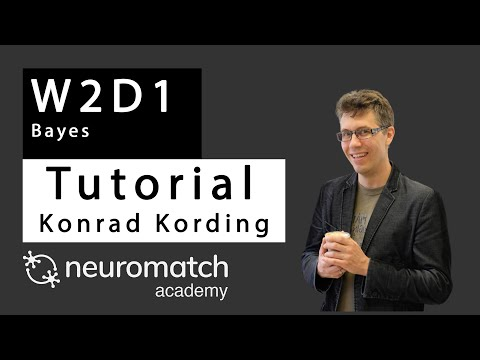

In [1]:
# @title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
##Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
# imports
import numpy as np                 
import matplotlib.pyplot as plt 

In [3]:
#@title Figure Settings
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
    
def my_gaussian(x_points, mu, sigma):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
    
    Args: 
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)

    px = px / px.sum() # this is the normalization part with a very strong assumption, that
                       # x_points cover the big portion of probability mass around the mean.
                       # Please think/discuss when this would be a dangerous assumption.
    
    return px

def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians
    
    Args: 
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
             
    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')
    

# Section 1: Motivating example

Ventriloquists produce the illusion that their puppets are talking because:
1. We observe the visual input of the puppet moving its mouth, as if speaking.
2. The speech that the puppeteer generates originates near the puppet's mouth. 

Since we are accustomed to voices coming from moving mouths, we tend to interpret the voice as coming directly from the puppet itself rather than from the puppeteer (who is also hiding his/her own mouth movements). In the remaining tutorials, we will study how this illusion breaks down as the distance between the visual stimulus (the puppet's mouth) and the auditory stimulus (the puppeter's concealed speech) changes. 

Imagine an experiment where participants are shown a puppet moving its mouth at a location directly in front of them (at position 0˚). The subjects are told that 75% of the time, the voice they hear originates from the puppet. On the remaining 25% of trials, sounds come from elsewhere. Participants learn this over multiple trials, after which a curtain is dropped in front of the puppeteer and the puppet. 

Next, we present only the auditory stimulus at varying locations and we ask participants to report where the source of the sound is located. The participants have access to two pieces of information:

*   The prior information about sound localization, learned during the trials before the curtain fell.
*   Their noisy sensory estimates about where a particular sound originates. 

Our eventual goal, which we achieve in Tutorial 3, is to predict the subjects' responses: when do subjects ascribe a sound to the puppet, and when do they believe it originated elsewhere? Doing so requires building a prior that captures the participant's knowledge and expectations, which we wil do in the exercises that follow here. 

# Section 2: Mixture-of-Gaussians Prior

In the previous tutorial, you learned how to create a single Gaussian prior that could represent one of these possibilties. A broad Gaussian with a large $\sigma$ could represent sounds originating from nearly anywhere, while a narrow Gaussian with $\mu$ near zero could represent sounds orginating from the puppet. 

Here, we will combine those into a mixure-of-Gaussians probability density function (PDF) that captures both possibilties. We will control how the Gaussians are mixed by summing them together with a 'mixing' or weight parameter $p_{common}$, set to a value between 0 and 1, like so:

\begin{eqnarray}
    \text{Mixture} = \bigl[\; p_{common} \times \mathcal{N}(\mu_{common},\sigma_{common}) \; \bigr] + \bigl[ \;\underbrace{(1-p_{common})}_{p_{independent}} \times \mathcal{N}(\mu_{independent},\sigma_{independent}) \; \bigr]
\end{eqnarray}

$p_{common}$ denotes the probability that auditory stimulus shares a "common" source with the learnt visual input; in other words, the probability that the "puppet" is speaking. You might think that we need to include a separate weight for the possibility that sound is "independent" from the puppet. nHowever, since there are only two, mutually-exclusive possibilties, we can replace $p_{independent}$ with $(1 - p_{common})$ since, by the law of total probability, $p_{common} + p_{independent}$ must equal one. 

Using the formula above, complete the code to build this mixture-of-Gaussians PDF: 
* Generate a Gaussian with mean 0 and standard deviation 0.5 to be the 'common' part of the Gaussian mixture prior. (This is already done for you below).
* Generate another Gaussian with mean 0 and standard deviation 3 to serve as the 'independent' part. 
* Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter $p_{common}$ = 0.75 so that the peakier "common-cause" Gaussian has 75% of the weight. Don't forget to normalize afterwards! 

Hints:
* Code for the `my_gaussian` function from Tutorial 1 is available for you to use. Its documentation is below. 


**Helper function(s)**


In [5]:
help(my_gaussian)

Help on function my_gaussian in module __main__:

my_gaussian(x_points, mu, sigma)
    DO NOT EDIT THIS FUNCTION !!!
    
    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
    
    Args: 
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`



## Exercise 1: Implement the prior 

In [6]:
def mixture_prior(x, mean=0, sigma_common=0.5, sigma_independent=3, p_common=0.75):

  ###############################################################################
  ## Insert your code here to:
  #   * Create a second gaussian representing the independent-cause component
  #   * Combine the two priors, using the mixing weight p_common. Don't forget
  #      to normalize the result so it remains a proper probability density function
  #
  #   * Comment the line below to test out your function   
  raise NotImplementedError("Please complete Exercise 1")
  ###############################################################################
  
  gaussian_common = my_gaussian(x, mean, sigma_common) 
  gaussian_independent = ...
  mixture = ...

  return gaussian_common, gaussian_independent, mixture


x = np.arange(-10, 11, 0.1)

# Uncomment the lines below to visualize out your solution
# common, independent, mixture = mixture_prior(x)
# plot_mixture_prior(x, common, independent, mixture)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_01b53c96.py)

*Example output:*

<img alt='Solution hint' align='left' width=424 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial2_Solution_01b53c96_2.png>




# Section 3: Bayes Theorem with Complex Posteriors

Video available at https://youtube.com/watch?v=LWKM35te0WI


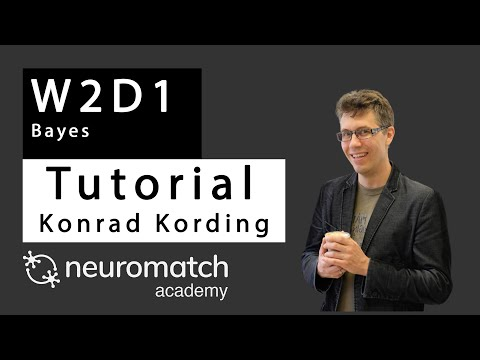

In [8]:
#@title Video 2: Mixture-of-Gaussians and Bayes' Theorem
video = YouTubeVideo(id='LWKM35te0WI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have created a mixture of Gaussians prior that embodies the participants' expectations about sound location, we want to compute the posterior probability, which represents the subjects' beliefs about a specific sound's origin. 

To do so we will compute the posterior by using *Bayes Theorem* to combine the mixture-of-gaussians prior and varying auditory Gaussian likelihood. This works exactly the same as in Tutorial 1: we simply multiply the prior and likelihood pointwise, then normalize the resulting distribution so it sums to 1. (The closed-form solution from Exercise 2B, however, no longer applies to this more complicated prior). 

Here, we provide you with the code mentioned in the video (lucky!). Instead, use the interactive demo to explore how a mixture-of-Gaussians prior and Gaussian likelihood interact. For simplicity, we have fixed the prior mean to be zero. We also recommend starting with same other prior parameters used in Exercise 1: $\sigma_{common} = 0.5, \sigma_{independent} = 3, p_{common}=0.75$; vary the likelihood instead. 

Unlike the demo in Tutorial 1, you should see several qualitatively different effects on the posterior, depending on the relative position and width of likelihood. Pay special attention to both the overall shape of the posterior and the location of the peak. What do you see?

## Interactive Demo 1: Mixture-of-Gaussian prior and the posterior

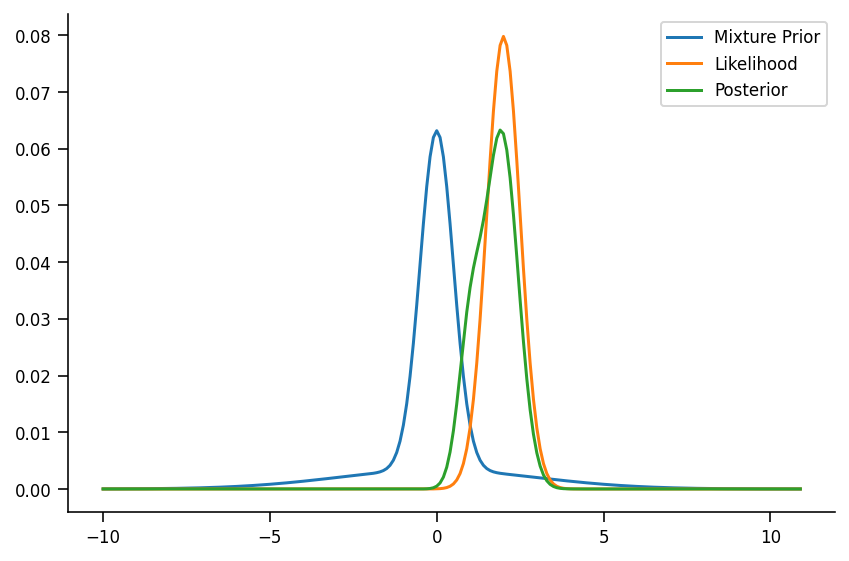

In [9]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

fig_domain = np.arange(-10, 11, 0.1)
import ipywidgets as widgets

def refresh(sigma_common=0.5, sigma_independent=3, p_common=0.75, mu_auditory=3, sigma_auditory=1.5):
    _, _, prior = mixture_prior(fig_domain, 0, sigma_common, sigma_independent, p_common)
    likelihood = my_gaussian(fig_domain, mu_auditory, sigma_auditory)

    posterior = prior * likelihood
    posterior /= posterior.sum()

    plt.plot(fig_domain, prior, label="Mixture Prior")
    plt.plot(fig_domain, likelihood, label="Likelihood")
    plt.plot(fig_domain, posterior, label="Posterior")

    plt.legend()

    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh, 
    sigma_common=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_common", style=style),
    sigma_independent=widgets.FloatSlider(value=3, min=0.01, max=10, step=0.5, description="sigma_independent:", style=style),
    p_common=widgets.FloatSlider(value=0.75, min=0, max=1, steps=0.01, description="p_common"),
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.1, description="mu_auditory:", style=style),
    sigma_auditory=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_auditory:", style=style),
)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_9569e15c.py)



# Section 3: Conclusion

Video available at https://youtube.com/watch?v=UgeAtE8xZT8


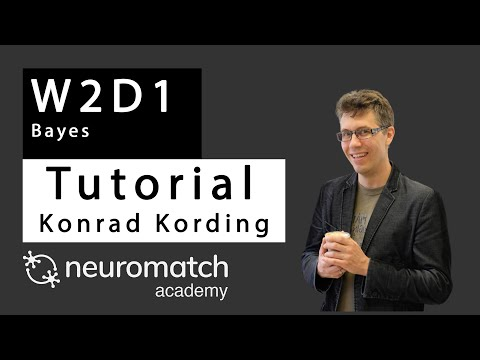

In [11]:
#@title Video 3: Outro
video = YouTubeVideo(id='UgeAtE8xZT8', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In this tutorial, we introduced the ventriloquism setting that will form the basis of Tutorials 3 and 4 as well. We built a mixture-of-Gaussians prior that captures the participants' subjective experiences. In the next tutorials, we will use these to perform causal inference and predict the subject's responses to indvidual stimuli. 